In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import os
import pickle
from tensorly.decomposition import non_negative_parafac

In [ ]:
import os
import tqdm
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

session_folder = os.listdir("/media/ubuntu/sda/neuropixels/output_dir")
activity_dict = {}  
num_bins = 20
for session in tqdm.tqdm(session_folder):
    if 'session_' not in session:
        continue
        
    trigger_time = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/stimulus_table_natural_movie.csv")
    trigger_time = trigger_time[trigger_time['stimulus_name'] == 'natural_movie_one']

    spike_inf = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/spike_inf_natural_movie.csv", index_col=0)
    
    filtered_spikes = spike_inf['id'].value_counts()
    filtered_spikes = filtered_spikes[filtered_spikes > 30000].index
    spike_inf = spike_inf[spike_inf['id'].isin(filtered_spikes)]
    
    regions = spike_inf['region'].unique()
    
    neuron_mappings = {}
    for region in regions:
        region_neurons = spike_inf[spike_inf['region'] == region]['id'].unique()
        region_neurons = np.intersect1d(region_neurons, filtered_spikes)
        
        if len(region_neurons) == 0:
            continue
            
        neuron_id_to_idx = {id: idx for idx, id in enumerate(region_neurons)}
        neuron_mappings[region] = {
            'neurons': region_neurons,
            'id_to_idx': neuron_id_to_idx,
            'n_neurons': len(region_neurons)
        }
    
    if not neuron_mappings:
        continue
        
    spike_times = spike_inf['time'].values
    spike_ids = spike_inf['id'].values
    spike_regions = spike_inf['region'].values
    
    for region in neuron_mappings:
        if region not in activity_dict:
            activity_dict[region] = {}
        activity_dict[region][session] = {}
    
    for image in range(900):
        trigger_time_temp = trigger_time[trigger_time['frame'] == image]
        
        for trial_idx, (_, row) in enumerate(trigger_time_temp.iterrows()):
            start_time = row['start_time']
            end_time = row['stop_time']
            duration = end_time - start_time
            
            mask = (spike_times >= start_time) & (spike_times < end_time)
            trial_spike_times = spike_times[mask] - start_time
            trial_spike_ids = spike_ids[mask]
            trial_spike_regions = spike_regions[mask]
            
            for region, mapping in neuron_mappings.items():
                region_mask = np.isin(trial_spike_regions, [region])
                region_spike_times = trial_spike_times[region_mask]
                region_spike_ids = trial_spike_ids[region_mask]
                
                n_neurons = mapping['n_neurons']
                neuron_id_to_idx = mapping['id_to_idx']
                
                if len(region_spike_times) == 0:
                    activity_matrix = np.zeros((n_neurons, num_bins))
                    activity_dict[region][session][f'{image}_{trial_idx}'] = activity_matrix
                    continue
                
                neuron_indices = np.array([neuron_id_to_idx[id] for id in region_spike_ids])
                
                counts, _, _ = np.histogram2d(
                    neuron_indices, 
                    region_spike_times,
                    bins=[n_neurons, num_bins],
                    range=[[0, n_neurons], [0, duration]]
                )
                
                bin_width = duration / num_bins
                firing_rates = counts / bin_width
                
                smoothed_rates = gaussian_filter1d(
                    firing_rates, 
                    sigma=2, 
                    axis=1,  
                    mode='nearest'
                )
                
                activity_dict[region][session][f'{image}_{trial_idx}'] = smoothed_rates

In [43]:
session = 'session_715093703'
trigger_time = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/stimulus_table_natural_movie.csv")
trigger_time = trigger_time[trigger_time['stimulus_name'] == 'natural_movie_one']
trigger_time = trigger_time[trigger_time['stimulus_block'] == 4.0]

spike_inf = pd.read_csv(f"/media/ubuntu/sda/neuropixels/output_dir/{session}/spike_inf_natural_movie.csv", index_col=0)
spike_inf = spike_inf[(spike_inf['time'] >= 2835.861732936706) & (spike_inf['time'] <= 3136.1125829367065)]
spike_inf = spike_inf[spike_inf['region'] == 'VISp']

filtered_spikes = spike_inf['id'].value_counts()
filtered_spikes = filtered_spikes[filtered_spikes > 1000].index
spike_inf = spike_inf[spike_inf['id'].isin(filtered_spikes)]

In [54]:
total_duration = 300.25085000000036  # 秒

bin_width = 0.033  # 33毫秒 = 0.033秒
n_bins = 9000

bin_edges = np.linspace(0 + spike_inf['time'].min(), total_duration + spike_inf['time'].min(), n_bins + 1)

firing_rates = pd.DataFrame(
    index=np.arange(n_bins),
    columns=spike_inf['id'].unique()
).fillna(0)  

spike_inf['bin_index'] = None
spike_inf['bin_index'] = np.digitize(spike_inf['time'], bin_edges) - 1

valid_bins = (spike_inf['bin_index'] >= 0) & (spike_inf['bin_index'] < n_bins)

bin_counts = spike_inf.groupby(['bin_index', 'id']).size().unstack(fill_value=0)

firing_rates.update(bin_counts)

firing_rates = firing_rates


#firing_rates['time'] = (bin_edges[:-1] + bin_edges[1:]) / 2



In [55]:
firing_rates

,950930105,950930276,950930237,950930215,950930358,950930407,950930392,950930375,950930866,950931004,...,950931805,950931770,950931751,950931727,950931853,950931899,950932102,950932087,950932032,950932563
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,2,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,1,0,0,0,2,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
3,0,0,0,0,0,1,0,0,1,1,...,0,1,0,3,1,1,0,2,0,3
4,0,0,0,0,0,4,0,0,0,0,...,1,3,0,1,0,2,0,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0,0,1,0,0,1,0,0,2,0,...,0,1,1,0,1,2,1,2,0,0
8996,0,0,0,0,1,2,0,0,0,0,...,0,1,1,1,1,0,0,1,0,0
8997,1,0,0,0,1,1,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0
8998,1,1,0,0,0,2,0,0,1,0,...,0,0,0,2,0,0,0,1,1,0


In [56]:
firing_rates.iloc[:60, :]

,950930105,950930276,950930237,950930215,950930358,950930407,950930392,950930375,950930866,950931004,...,950931805,950931770,950931751,950931727,950931853,950931899,950932102,950932087,950932032,950932563
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,2,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,1,0,0,0,2,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
3,0,0,0,0,0,1,0,0,1,1,...,0,1,0,3,1,1,0,2,0,3
4,0,0,0,0,0,4,0,0,0,0,...,1,3,0,1,0,2,0,1,1,5
5,1,0,0,0,0,3,0,0,1,0,...,1,2,0,1,1,3,0,1,0,1
6,0,0,0,0,0,3,0,1,0,0,...,0,0,0,1,1,0,0,1,1,3
7,0,1,0,1,0,3,0,0,1,1,...,0,1,0,1,1,0,0,1,1,2
8,0,0,0,0,1,2,0,0,0,0,...,1,1,0,0,0,1,0,0,1,3
9,1,1,0,0,0,4,0,0,0,0,...,0,0,0,1,1,1,0,1,1,2


<Axes: >

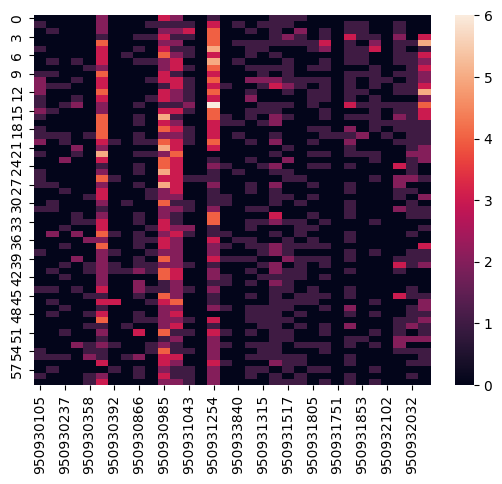

In [57]:
sns.heatmap(firing_rates.iloc[:60, :])

In [46]:
np.sum(firing_rates.iloc[:, 0])

4267

In [70]:
import numpy as np
import cv2
import os

def generate_circular_grating_videos(output_dir, frame_rates=[5, 15, 30, 60], 
                                    resolution=(800, 800), spatial_freq=0.05, 
                                    contrast=0.9, anti_alias=True, 
                                    circle_radius=None, background_gray=127,
                                    soft_edge=10):
    """
    生成圆形区域内的旋转黑白光栅视频
    
    参数:
    output_dir - 输出目录路径
    frame_rates - 需要生成的帧率列表 (默认[5,15,30,60])
    resolution - 视频分辨率 (默认800x800)
    spatial_freq - 光栅空间频率 (默认0.05 cycles/pixel)
    contrast - 对比度 (0-1, 默认0.9)
    anti_alias - 是否启用抗锯齿处理 (默认True)
    circle_radius - 圆形区域半径 (默认是图像宽度或高度的40%)
    background_gray - 背景灰度值 (0-255, 默认127=中灰)
    soft_edge - 圆形边缘软化宽度 (像素, 默认10)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    width, height = resolution
    total_frames = 360  # 总帧数 (0-359度)
    
    # 设置默认圆形半径
    if circle_radius is None:
        circle_radius = min(width, height) * 0.4
    
    # 创建亚像素精度的网格坐标 (用于抗锯齿)
    scale = 2 if anti_alias else 1
    x = np.linspace(-width//2, width//2, width * scale)
    y = np.linspace(-height//2, height//2, height * scale)
    X, Y = np.meshgrid(x, y)
    
    # 创建距离场 (用于圆形区域)
    R = np.sqrt(X**2 + Y**2)
    
    # 创建圆形掩模 (带软边缘)
    mask = np.ones_like(R)
    if soft_edge > 0:
        # 软边缘: 在半径附近创建平滑过渡
        inner_radius = circle_radius - soft_edge/2
        outer_radius = circle_radius + soft_edge/2
        mask = np.clip((outer_radius - R) / soft_edge, 0, 1)
    else:
        # 硬边缘: 圆形内部为1，外部为0
        mask = (R <= circle_radius).astype(float)
    
    for fps in frame_rates:
        # 创建视频文件
        filename = os.path.join(output_dir, f"circular_grating_{fps}fps.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(filename, fourcc, fps, (width, height))
        
        print(f"生成圆形光栅视频 ({fps} FPS): {filename}")
        print(f"圆形半径: {circle_radius:.1f}px, 软边缘: {soft_edge}px")
        
        # 生成360帧 (每帧1度)
        for angle in range(total_frames):
            # 计算当前角度的光栅方向 (弧度)
            theta = np.deg2rad(angle)
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            
            # 计算光栅方向投影
            direction = cos_theta * X + sin_theta * Y
            
            # 生成正弦光栅 (灰度渐变)
            grating = np.sin(2 * np.pi * spatial_freq * direction)
            
            # 应用对比度调整
            grating = grating * contrast
            
            # 将灰度值从[-contrast, contrast]映射到[0,255]
            grating = ((grating + contrast) / (2 * contrast) * 255)
            
            # 应用圆形掩模
            combined = grating * mask + background_gray * (1 - mask)
            
            if anti_alias:
                # 降采样到目标分辨率
                combined = cv2.resize(combined, (width, height), interpolation=cv2.INTER_AREA)
            
            # 转换为8位整数
            frame_gray = np.clip(combined, 0, 255).astype(np.uint8)
            
            # 转换为三通道图像
            frame = cv2.merge([frame_gray, frame_gray, frame_gray])
            
            # 写入视频帧
            video.write(frame)
            
            # 显示进度
            if angle % 90 == 0:
                print(f"角度: {angle}度, 进度: {angle/3.6:.1f}%")
        
        video.release()
        print(f"完成! 已生成 {total_frames} 帧, 时长: {total_frames/fps:.2f} 秒")


output_directory = "smooth_grating_videos"

generate_circular_grating_videos(output_directory, 
                                frame_rates=[5, 15, 30, 60],
                                resolution=(800, 800),
                                spatial_freq=0.04,
                                contrast=0.95,
                                circle_radius=375,
                                soft_edge=5)

生成圆形光栅视频 (5 FPS): smooth_grating_videos/circular_grating_5fps.mp4
圆形半径: 375.0px, 软边缘: 5px
角度: 0度, 进度: 0.0%
角度: 90度, 进度: 25.0%
角度: 180度, 进度: 50.0%
角度: 270度, 进度: 75.0%
完成! 已生成 360 帧, 时长: 72.00 秒
生成圆形光栅视频 (15 FPS): smooth_grating_videos/circular_grating_15fps.mp4
圆形半径: 375.0px, 软边缘: 5px
角度: 0度, 进度: 0.0%
角度: 90度, 进度: 25.0%
角度: 180度, 进度: 50.0%
角度: 270度, 进度: 75.0%
完成! 已生成 360 帧, 时长: 24.00 秒
生成圆形光栅视频 (30 FPS): smooth_grating_videos/circular_grating_30fps.mp4
圆形半径: 375.0px, 软边缘: 5px
角度: 0度, 进度: 0.0%
角度: 90度, 进度: 25.0%
角度: 180度, 进度: 50.0%
角度: 270度, 进度: 75.0%
完成! 已生成 360 帧, 时长: 12.00 秒
生成圆形光栅视频 (60 FPS): smooth_grating_videos/circular_grating_60fps.mp4
圆形半径: 375.0px, 软边缘: 5px
角度: 0度, 进度: 0.0%
角度: 90度, 进度: 25.0%
角度: 180度, 进度: 50.0%
角度: 270度, 进度: 75.0%
完成! 已生成 360 帧, 时长: 6.00 秒
